In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [63]:
data_login_logs = pd.read_csv('login_logs.csv')
data_subscription_logs = pd.read_csv('subscription_logs.csv')
data_view_logs = pd.read_csv('view_logs.csv')

**DAU, WAU, MAU, Stickiness 분석**

In [29]:
data_login_logs['login_time'] = pd.to_datetime(data_login_logs['login_time'])

In [30]:
data_login_logs['date'] = data_login_logs['login_time'].dt.date
data_login_logs['week'] = data_login_logs['login_time'].dt.isocalendar().week
data_login_logs['month'] = data_login_logs['login_time'].dt.to_period('M')
data_login_logs['year'] = data_login_logs['login_time'].dt.year

In [31]:
dau = data_login_logs.groupby('date')['user_id'].nunique().reset_index(name='DAU')
dau['year'] = pd.to_datetime(dau['date']).dt.year
wau = data_login_logs.groupby('week')['user_id'].nunique().reset_index(name='WAU')
mau = data_login_logs.groupby('month')['user_id'].nunique().reset_index(name='MAU')
mau['year'] = mau['month'].dt.year

In [32]:
annual_dau = dau.groupby('year')['DAU'].mean().reset_index(name='Average_DAU')
annual_mau = mau.groupby('year')['MAU'].mean().reset_index(name='Average_MAU')

annual_stickiness = pd.merge(annual_dau, annual_mau, on='year')
annual_stickiness['Stickiness (%)'] = (annual_stickiness['Average_DAU'] / annual_stickiness['Average_MAU']) * 100

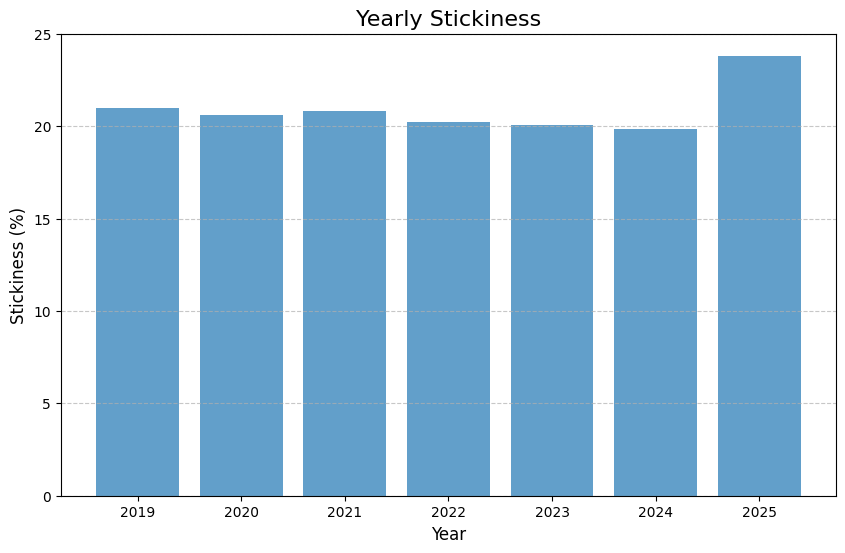

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(annual_stickiness['year'], annual_stickiness['Stickiness (%)'], alpha=0.7)
plt.title('Yearly Stickiness', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Stickiness (%)', fontsize=12)
plt.xticks(annual_stickiness['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**재구독율 분석**

In [38]:
data_subscription_logs['subscription_start'] = pd.to_datetime(data_subscription_logs['subscription_start'])
data_subscription_logs['subscription_end'] = pd.to_datetime(data_subscription_logs['subscription_end'])

In [52]:
subscription_counts = data_subscription_logs.groupby('user_id')['subscription_start'].count().reset_index(name='subscription_count')

In [54]:
# 재구독자 수
resubscribed_users = subscription_counts[subscription_counts['subscription_count'] > 1]['user_id'].nunique()

In [59]:
# 전체 이탈 사용자 수
churners = subscription_counts[subscription_counts['subscription_count'] == 1]['user_id'].nunique()

In [60]:
# 재구독율 계산
resubscription_rate = (resubscribed_users / churners) * 100

In [61]:
print(f"전체 이탈 사용자 수: {churners}")
print(f"재구독 사용자 수: {resubscribed_users}")
print(f"재구독율: {resubscription_rate:.2f}%")

전체 이탈 사용자 수: 2750
재구독 사용자 수: 2693
재구독율: 97.93%


**추천 알고리즘 효과성 분석**

In [64]:
data_view_logs['recommended'] = data_view_logs['recommended'].astype(bool)

In [70]:
recommended_views = data_view_logs[data_view_logs['recommended'] == True]
non_recommended_views = data_view_logs[data_view_logs['recommended'] == False]

In [73]:
# 추천 콘텐츠 완료율
total_recommended = len(recommended_views)  # 추천된 콘텐츠의 총 추천 횟수
completed_recommended = len(recommended_views[recommended_views['is_completed'] == True])  # 추천 콘텐츠 중 완료된 수
completion_rate_recommended = (completed_recommended / total_recommended) * 100

In [74]:
# 평균 시청 시간 비교
avg_watch_time_recommended = recommended_views['watched_duration'].mean()
avg_watch_time_non_recommended = non_recommended_views['watched_duration'].mean()

# 결과 출력
print(f"추천 콘텐츠 시청완료율: {completion_rate_recommended:.2f}%")
print(f"추천 콘텐츠 평균 시청 시간: {avg_watch_time_recommended:.2f}초")
print(f"비추천 콘텐츠 평균 시청 시간: {avg_watch_time_non_recommended:.2f}초")

추천 콘텐츠 시청완료율: 49.97%
추천 콘텐츠 평균 시청 시간: 3755.44초
비추천 콘텐츠 평균 시청 시간: 3744.68초


In [ ]:
# CTR(Click-Through Rate, 클릭률)도 함께 분석하려 했으나, watch duration의 값이 대체로 커서 기준값을 단순히 0초, 혹은 10초 이상으로 설정하면 모든 데이터가 해당되어서 제외함
## 추천 알고리즘을 통해 콘텐츠를 시청 완료한 비율이 높다고 볼 수 없음
### 추천 콘텐츠의 평균 시청 시간과 비추천 콘텐츠 평균 시청 시간이 큰 차이가 나지 않는 것으로 보아 컨텐츠 소비에 효과적으로 작동한다고는 볼 수 없음

**A/B 테스트 설계**

In [ ]:
# Control 그룹: 기존 추천 알고리즘.
# Test 그룹: 새로운 추천 알고리즘.
## 지표: {완료율: 추천된 콘텐츠를 끝까지 시청한 비율, 평균 시청 시간: 추천 콘텐츠의 평균 시청 시간, 세그먼트 분석: 연령대 또는 기기 유형별로 분석}

In [76]:
# A/B 그룹 설정
np.random.seed(42)
user_ids = data_view_logs['user_id'].unique()
user_groups = pd.DataFrame({
    'user_id': user_ids,
    'group': np.random.choice(['control', 'test'], size=len(user_ids), p=[0.5, 0.5])
})
view_logs_with_groups = data_view_logs.merge(user_groups, on='user_id')

# Control 그룹과 Test 그룹 분리
control_group = view_logs_with_groups[view_logs_with_groups['group'] == 'control']
test_group = view_logs_with_groups[view_logs_with_groups['group'] == 'test']

In [77]:
# 완료율 계산 함수
def calculate_completion_rate(group):
    completed = len(group[group['is_completed'] == True])
    total = len(group)
    return (completed / total) * 100

# Control 및 Test 그룹 완료율
control_completion_rate = calculate_completion_rate(control_group)
test_completion_rate = calculate_completion_rate(test_group)

In [78]:
# 평균 시청 시간 계산 함수
def calculate_avg_watch_time(group):
    return group['watched_duration'].mean()

# Control 및 Test 그룹 평균 시청 시간
control_avg_watch_time = calculate_avg_watch_time(control_group)
test_avg_watch_time = calculate_avg_watch_time(test_group)

In [79]:
# 통계적 유의성 검증 (완료율)
control_completed = control_group['is_completed'].astype(int)  # 완료 여부를 1(True)/0(False)로 변환
test_completed = test_group['is_completed'].astype(int)
t_stat_completion, p_value_completion = ttest_ind(control_completed, test_completed)

In [80]:
# 통계적 유의성 검증 (평균 시청 시간)
t_stat_watch_time, p_value_watch_time = ttest_ind(control_group['watched_duration'], test_group['watched_duration'])

In [81]:
# 결과 출력
print(f"Control 그룹 완료율: {control_completion_rate:.2f}%")
print(f"Test 그룹 완료율: {test_completion_rate:.2f}%")
print(f"Control 그룹 평균 시청 시간: {control_avg_watch_time:.2f}초")
print(f"Test 그룹 평균 시청 시간: {test_avg_watch_time:.2f}초")
print(f"완료율 T-검정: T-Statistic={t_stat_completion:.3f}, P-Value={p_value_completion:.3f}")
print(f"평균 시청 시간 T-검정: T-Statistic={t_stat_watch_time:.3f}, P-Value={p_value_watch_time:.3f}")

Control 그룹 완료율: 49.77%
Test 그룹 완료율: 49.98%
Control 그룹 평균 시청 시간: 3743.75초
Test 그룹 평균 시청 시간: 3749.89초
완료율 T-검정: T-Statistic=-1.158, P-Value=0.247
평균 시청 시간 T-검정: T-Statistic=-0.848, P-Value=0.396


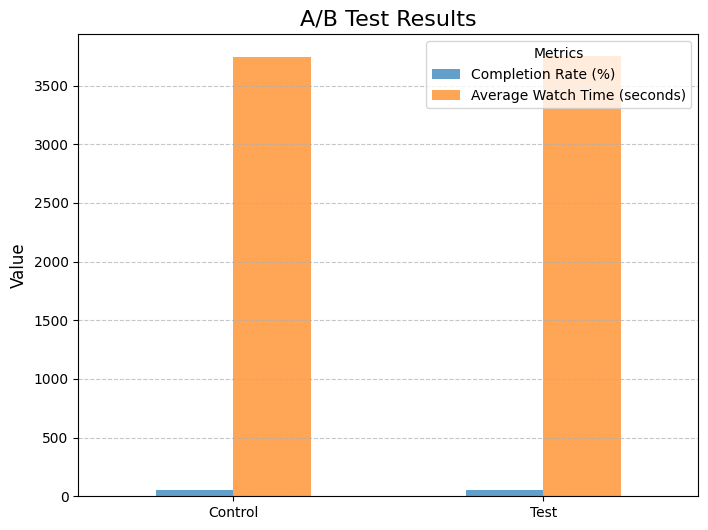

In [82]:
# 결과 시각화
metrics = {
    'Completion Rate (%)': [control_completion_rate, test_completion_rate],
    'Average Watch Time (seconds)': [control_avg_watch_time, test_avg_watch_time]
}
metrics_df = pd.DataFrame(metrics, index=['Control', 'Test'])

metrics_df.plot(kind='bar', figsize=(8, 6), alpha=0.7)
plt.title('A/B Test Results', fontsize=16)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrics')
plt.show()